# Task 
You are given a `ham` (0) - `spam` (1) dataset. Follow the instructions given below and answer the questions: 
1. Build a tf-idf model and get the confusion matrix. Keep it as your baseline model. Do you notice anything worth looking into? 
2. Use a transformer-based language model to extract keywords from your training dataset that are not already there in the baseline model’s tf-idf vocabulary and may help in classification. Update the vocabulary of the tf-idf model. 
3. Train another model with the updated vocabulary and see if it makes any difference to your confusion matrix. Please provide reasons for the changes observed. Perform any necessary analytics to support your conclusion. 
4. If you have time, try different transformer-based keyword extraction methods, update the vocabulary, train the tf-idf model and compare your results. What do you see? Perform any necessary analytics to support your conclusion.   

**Note**: Steps 1-3 are mandatory, step 4 is optional.

# Importing Required Libraries

In [23]:
# !pip3 install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.0 MB/s eta 0:00:00a 0:00:01


In [31]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from transformers import pipeline

import matplotlib.pyplot as plt
import wordcloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

pd.set_option('display.max_colwidth', 10000) 
pd.set_option('display.max_rows', 200)

In [3]:
X_train_df = pd.read_csv('data/X_train.csv')
X_test_df = pd.read_csv('data/X_test.csv', usecols=['text'])
y_train_df = pd.read_csv('data/y_train.csv')
y_test_df = pd.read_csv('data/y_test.csv', usecols=['label'])
X_train_df.shape, y_train_df.shape, X_test_df.shape, y_test_df.shape

((200, 1), (200, 1), (1115, 1), (1115, 1))

### As the train test split is not usual swapping train and test

In [4]:
X_test_df = pd.read_csv('data/X_train.csv')
X_train_df = pd.read_csv('data/X_test.csv', usecols=['text'])
y_test_df = pd.read_csv('data/y_train.csv')
y_train_df = pd.read_csv('data/y_test.csv', usecols=['label'])
X_train_df.shape, y_train_df.shape, X_test_df.shape, y_test_df.shape

((1115, 1), (1115, 1), (200, 1), (200, 1))

### Combining the dataset inorder to do pre processing and EDA

In [5]:
# Adding labels and combining the dataset
X_test_df['XTrainTest'] = 'X_test'
X_train_df['XTrainTest'] = 'X_train'
y_test_df['yTrainTest'] = 'y_test'
y_train_df['yTrainTest'] = 'y_train'

In [6]:
#Stacking the dfs horizontally and vertically
X = pd.concat([X_train_df, X_test_df], axis=0)
y = pd.concat([y_train_df, y_test_df], axis=0)
df = pd.concat([X,y],axis=1)
df.head()

,text,XTrainTest,label,yTrainTest
0,"Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens",X_train,0,y_train
1,"I sent my scores to sophas and i had to do secondary application for a few schools. I think if you are thinking of applying, do a research on cost also. Contact joke ogunrinde, her school is one me the less expensive ones",X_train,0,y_train
2,"We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p",X_train,1,y_train
3,Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me know you made it in ok.,X_train,0,y_train
4,Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16,X_train,1,y_train


In [7]:
df.shape

(1315, 4)

# EDA

In [8]:
df['label'].value_counts()

label
0    1138
1     177
Name: count, dtype: int64

In [9]:
# shows data set is not balanced properly
df['label'].value_counts(normalize=True)*100

label
0    86.539924
1    13.460076
Name: proportion, dtype: float64

In [10]:
# checking for NULL
df.isnull().sum()

text          0
XTrainTest    0
label         0
yTrainTest    0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1315 entries, 0 to 199
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1315 non-null   object
 1   XTrainTest  1315 non-null   object
 2   label       1315 non-null   int64 
 3   yTrainTest  1315 non-null   object
dtypes: int64(1), object(3)
memory usage: 51.4+ KB


In [12]:
df['text_len'] = df['text'].str.len()
df.head()

,text,XTrainTest,label,yTrainTest,text_len
0,"Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens",X_train,0,y_train,151
1,"I sent my scores to sophas and i had to do secondary application for a few schools. I think if you are thinking of applying, do a research on cost also. Contact joke ogunrinde, her school is one me the less expensive ones",X_train,0,y_train,221
2,"We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p",X_train,1,y_train,101
3,Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me know you made it in ok.,X_train,0,y_train,124
4,Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16,X_train,1,y_train,150


Text(0.5, 0, 'Message Length')

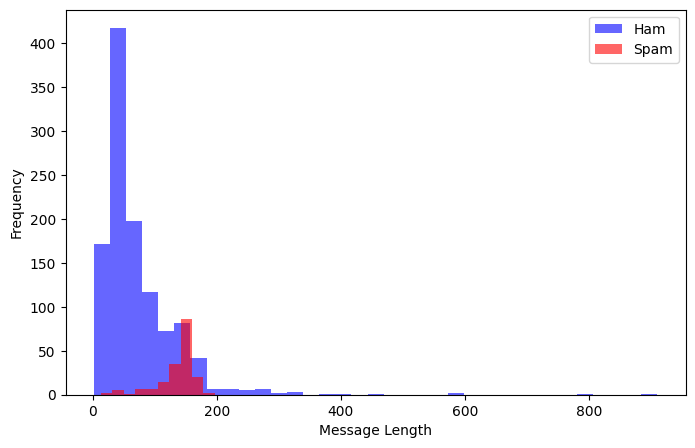

In [13]:
plt.figure(figsize=(8, 5))
df[df['label'] == 0]['text'].str.len().plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
df[df['label'] == 1]['text'].str.len().plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [14]:
def show_wordcloud(df, title):
    text = ' '.join(df['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='white',
                    colormap='viridis', width=1000, height=500).generate(text)
    
    plt.figure(figsize=(8,10), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=15 )
    plt.show()

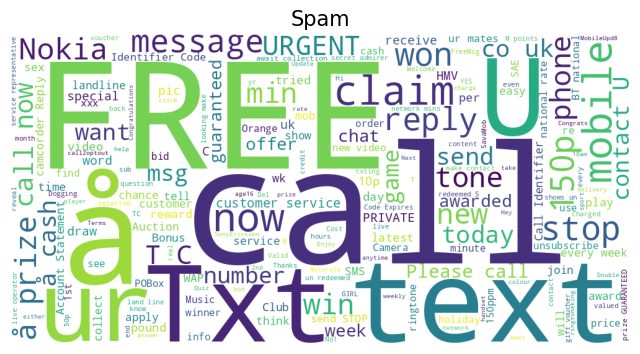

In [15]:
show_wordcloud(df[df['label']==1],'Spam')

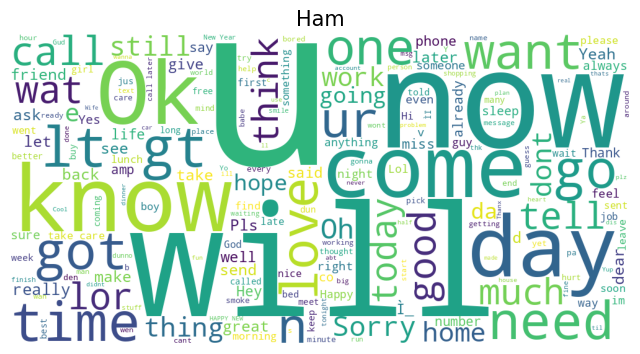

In [16]:
show_wordcloud(df[df['label']==0],'Ham')

# Data Preprocessing
## Cleaning

### Replace irrelvant info with generic keyword like email, website, phone number, etc
It simplifies text data, streamlining the analysis by reducing the complexity and variability within the data.

In [18]:
# replace email address with 'emailaddress'
df['text'] = df['text'].replace(to_replace=r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', value='emailaddress', regex=True)

# replace urls with 'webaddress'
df['text'] = df['text'].replace(to_replace=r'https?://\S+', value='webaddress', regex=True)
df['text'] = df['text'].replace(to_replace=r'www\.\S+', value='webaddress', regex=True)

# replace 10 digit phone number with 'phone-number'
df['text'] = df['text'].replace(to_replace=r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', value='phonenumber', regex=True)

# replace normal number with 'number'
df['text'] = df['text'].replace(to_replace=r'\d+(\.\d+)?', value='number', regex=True)

### Remove Punctuation, white spaces & convert case to lower
It simplifies text data, streamlining the analysis by reducing the complexity and variability within the data.

In [20]:
# remove punctuation
df['text'] = df['text'].replace(to_replace=r'[^\w\d\s]', value='', regex=True)

# remove whitespace between terms with single space
df['text'] = df['text'].replace(to_replace=r'\s+', value=' ', regex=True)

# remove leading and trailing whitespace
df['text'] = df['text'].replace(to_replace=r'^\s+|\s*?$', value=' ', regex=True)

# change words to lower case
df['text'] = df['text'].str.lower()

In [22]:
df[df['label']==1].head()

,text,XTrainTest,label,yTrainTest,text_len
2,we know someone who you know that fancies you call number to find out who pobox number lsnumberhb numberp,X_train,1,y_train,101
4,congratulations ur awarded either ånumber of cd gift vouchers free entry number our ånumber weekly draw txt music to number tncs webaddress,X_train,1,y_train,150
11,free tones hope you enjoyed your new content text stop to number to unsubscribe helpnumberp provided by tonesnumberyoucouk,X_train,1,y_train,129
17,urgent your mobile was awarded a ånumbernumber bonus caller prize on numbernumbernumber our final attempt number contact u call number,X_train,1,y_train,120
24,this is the numbernd time we have tried number contact u u have won the ånumber pound prize number claim is easy call number nownumber only numberp per minute btnationalrate,X_train,1,y_train,161


In [27]:
# import nltk
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Tokenize
Tokenization is the process of breaking down large blocks of text such as paragraphs and sentences into smaller, more manageable units.

In [28]:
df['text'] = df['text'].apply(word_tokenize)
df.head()

,text,XTrainTest,label,yTrainTest,text_len
0,"[funny, fact, nobody, teaches, volcanoes, number, erupt, tsunamis, number, arise, hurricanes, number, sway, aroundn, no, number, teaches, hw, number, choose, a, wife, natural, disasters, just, happens]",X_train,0,y_train,151
1,"[i, sent, my, scores, to, sophas, and, i, had, to, do, secondary, application, for, a, few, schools, i, think, if, you, are, thinking, of, applying, do, a, research, on, cost, also, contact, joke, ogunrinde, her, school, is, one, me, the, less, expensive, ones]",X_train,0,y_train,221
2,"[we, know, someone, who, you, know, that, fancies, you, call, number, to, find, out, who, pobox, number, lsnumberhb, numberp]",X_train,1,y_train,101
3,"[only, if, you, promise, your, getting, out, as, soon, as, you, can, and, youll, text, me, in, the, morning, to, let, me, know, you, made, it, in, ok]",X_train,0,y_train,124
4,"[congratulations, ur, awarded, either, ånumber, of, cd, gift, vouchers, free, entry, number, our, ånumber, weekly, draw, txt, music, to, number, tncs, webaddress]",X_train,1,y_train,150


## Stopword Removal
Stopword Removal is the process of eliminating common, frequently used words like "the," "a," "and," "is" from a text during data pre-processing, as these words carry little semantic meaning and do not contribute significantly to understanding the overall context, allowing the NLP model to focus on more important keywords for analysis. 

In [30]:
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [token for token in x if token not in stop_words])
df.head()

,text,XTrainTest,label,yTrainTest,text_len
0,"[funny, fact, nobody, teaches, volcanoes, number, erupt, tsunamis, number, arise, hurricanes, number, sway, aroundn, number, teaches, hw, number, choose, wife, natural, disasters, happens]",X_train,0,y_train,151
1,"[sent, scores, sophas, secondary, application, schools, think, thinking, applying, research, cost, also, contact, joke, ogunrinde, school, one, less, expensive, ones]",X_train,0,y_train,221
2,"[know, someone, know, fancies, call, number, find, pobox, number, lsnumberhb, numberp]",X_train,1,y_train,101
3,"[promise, getting, soon, youll, text, morning, let, know, made, ok]",X_train,0,y_train,124
4,"[congratulations, ur, awarded, either, ånumber, cd, gift, vouchers, free, entry, number, ånumber, weekly, draw, txt, music, number, tncs, webaddress]",X_train,1,y_train,150


## Stemming
Stemming is a technique in natural language processing (NLP) that reduces words to their root form, or stem. For example, the stem of the words “eating,” “eats,” and “eaten” is “eat”. 


In [32]:
ps = nltk.PorterStemmer()
df['text'] = df['text'].apply(lambda x: [ps.stem(token) for token in x])
df.head()

,text,XTrainTest,label,yTrainTest,text_len
0,"[funni, fact, nobodi, teach, volcano, number, erupt, tsunami, number, aris, hurrican, number, sway, aroundn, number, teach, hw, number, choos, wife, natur, disast, happen]",X_train,0,y_train,151
1,"[sent, score, sopha, secondari, applic, school, think, think, appli, research, cost, also, contact, joke, ogunrind, school, one, less, expens, one]",X_train,0,y_train,221
2,"[know, someon, know, fanci, call, number, find, pobox, number, lsnumberhb, numberp]",X_train,1,y_train,101
3,"[promis, get, soon, youll, text, morn, let, know, made, ok]",X_train,0,y_train,124
4,"[congratul, ur, award, either, ånumber, cd, gift, voucher, free, entri, number, ånumber, weekli, draw, txt, music, number, tnc, webaddress]",X_train,1,y_train,150


## Lemmatization 
Lemmatization is the process of reducing words to their base or dictionary form, known as the lemma. 

In [33]:
wn = nltk.WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: [wn.lemmatize(token) for token in x])
df.head()

,text,XTrainTest,label,yTrainTest,text_len
0,"[funni, fact, nobodi, teach, volcano, number, erupt, tsunami, number, aris, hurrican, number, sway, aroundn, number, teach, hw, number, choos, wife, natur, disast, happen]",X_train,0,y_train,151
1,"[sent, score, sopha, secondari, applic, school, think, think, appli, research, cost, also, contact, joke, ogunrind, school, one, less, expens, one]",X_train,0,y_train,221
2,"[know, someon, know, fanci, call, number, find, pobox, number, lsnumberhb, numberp]",X_train,1,y_train,101
3,"[promis, get, soon, youll, text, morn, let, know, made, ok]",X_train,0,y_train,124
4,"[congratul, ur, award, either, ånumber, cd, gift, voucher, free, entri, number, ånumber, weekli, draw, txt, music, number, tnc, webaddress]",X_train,1,y_train,150


In [21]:
def get_numpy_array(df):
    return df.to_numpy().reshape(-1)

In [22]:
# Train baseline tf-idf model
def train_baseline_tfidf(X_train, y_train, X_test, y_test):
    """Trains a tf-idf model and evaluates its performance."""
    tfidf = TfidfVectorizer()
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    model = MultinomialNB()
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    print("Baseline Model Performance:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return tfidf

In [23]:
# Extract keywords using transformer-based model
def extract_keywords(X_train, existing_vocab):
    """Extracts new keywords using a transformer-based model."""
    keyword_extractor = pipeline('ner', model='dbmdz/bert-large-cased-finetuned-conll03-english')
    
    new_keywords = set()
    for text in X_train:
        entities = keyword_extractor(text)
        for entity in entities:
            word = entity['word'].lower()
            if word not in existing_vocab:
                new_keywords.add(word)

    return new_keywords

In [24]:
# Update tf-idf vocabulary
def update_tfidf_vocabulary(tfidf, new_keywords):
    """Updates the tf-idf model vocabulary with new keywords."""
    existing_vocab = set(tfidf.vocabulary_.keys())
    updated_vocab = existing_vocab.union(new_keywords)
    return TfidfVectorizer(vocabulary=updated_vocab)

In [25]:
# Train updated tf-idf model
def train_updated_tfidf(X_train, y_train, X_test, y_test, updated_tfidf):
    """Trains and evaluates the model with the updated tf-idf vocabulary."""
    X_train_tfidf = updated_tfidf.fit_transform(X_train)
    X_test_tfidf = updated_tfidf.transform(X_test)

    model = MultinomialNB()
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    print("Updated Model Performance:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [ ]:
X_train = get_numpy_array(X_train_df)
X_test =get_numpy_array(X_test_df)
y_train = get_numpy_array(y_train_df)
y_test =get_numpy_array(y_test_df)
X_train_df.shape, y_train_df.shape, X_test_df.shape, y_test_df.shape

((1115, 2), (1115, 2), (200, 2), (200, 2))

In [ ]:
tfidf = train_baseline_tfidf(X_train, y_train, X_test, y_test)

TypeError: '<' not supported between instances of 'str' and 'int'

In [10]:
# new_keywords = extract_keywords(X_train, tfidf.vocabulary_)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [11]:
# updated_tfidf = update_tfidf_vocabulary(tfidf, new_keywords)

In [12]:
# train_updated_tfidf(X_train, y_train, X_test, y_test, updated_tfidf)

Updated Model Performance:
[[965   0]
 [146   4]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       965
           1       1.00      0.03      0.05       150

    accuracy                           0.87      1115
   macro avg       0.93      0.51      0.49      1115
weighted avg       0.89      0.87      0.81      1115

